In [560]:
''' Imports and global settings '''
from os import listdir
from os.path import join

import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

from matplotlib import pyplot as plt

CAPUCHIN_FILES_FOLDER = join('data', 'Parsed_Capuchinbird_Clips')
NON_CAPUCHIN_FILES_FOLDER = join('data', 'Parsed_Not_Capuchinbird_Clips')

CAPUCHIN_FILE_EXAMPLE = join(CAPUCHIN_FILES_FOLDER, 'XC3776-3.wav')
NON_CAPUCHIN_FILE_EXAMPLE = join(NON_CAPUCHIN_FILES_FOLDER, 'afternoon-birds-song-in-forest-0.wav')

In [548]:
''' Load a wav file and add 16k of signal and mono-channel '''
def load_wav_16k_mono(filepath: str):
  file_content = tf.io.read_file(filepath)

  # Get wav audio and sample-rate
  wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
  wav = tf.squeeze(wav, axis=1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  # Convert 44100Hz to 16000Hz (amplitude of the audio signal)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

  return wav

In [549]:
''' Print base tensors of wav files '''
capuchin_wav = load_wav_16k_mono(CAPUCHIN_FILE_EXAMPLE)
non_capuchin_wav = load_wav_16k_mono(NON_CAPUCHIN_FILE_EXAMPLE)

print(capuchin_wav)
print(non_capuchin_wav)

tf.Tensor(
[ 8.9910554e-07 -2.7947258e-06  7.0741157e-06 ... -1.0823049e-02
 -3.5766482e-03  1.5143131e-02], shape=(48000,), dtype=float32)
tf.Tensor(
[ 0.          0.          0.         ... -0.00054067  0.02472705
 -0.00794304], shape=(48927,), dtype=float32)


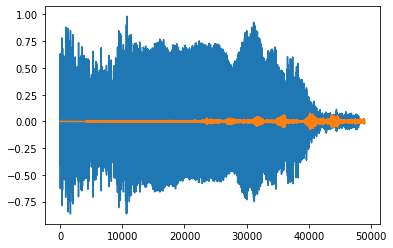

In [550]:
''' Plot base tensors of wav files '''
plt.plot(capuchin_wav)
plt.plot(non_capuchin_wav)
plt.show()

In [551]:
''' Create tensorflow datasets '''
pos_ds = tf.data.Dataset.list_files(f'{CAPUCHIN_FILES_FOLDER}/*.wav') 
neg_ds = tf.data.Dataset.list_files(f'{NON_CAPUCHIN_FILES_FOLDER}/*.wav')

''' Add labels and combine positive and negative samples '''
pos_ds_labeled = tf.data.Dataset.zip((pos_ds, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos_ds)))))
neg_ds_labeled = tf.data.Dataset.zip((neg_ds, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg_ds)))))

ds = pos_ds_labeled.concatenate(neg_ds_labeled)

In [552]:
''' Determine average length of a Capuchin call '''
''' Calculate wave cycle length '''
lengths = []

for filepath in listdir(CAPUCHIN_FILES_FOLDER):
  tensor_wave = load_wav_16k_mono(join(CAPUCHIN_FILES_FOLDER, filepath))
  lengths.append(len(tensor_wave))

''' Calculate mean, min and max '''
mean = tf.math.reduce_mean(lengths)
min = tf.math.reduce_min(lengths) 
max = tf.math.reduce_max(lengths)

print(mean)
print(min)
print(max)

tf.Tensor(54156, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)


In [553]:
''' Build preprocessing function to convert to spectogram '''
def convert_wav_to_spectogram(filepath: str, label: int):
  # Get wav file and cut until have 48000 steps
  wav = load_wav_16k_mono(filepath)
  wav = wav[:48000]

  # Add zero padding to wav files that have less than 48000 steps
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)

  # Create a spectogram with STFT
  spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)

  return spectogram, label 

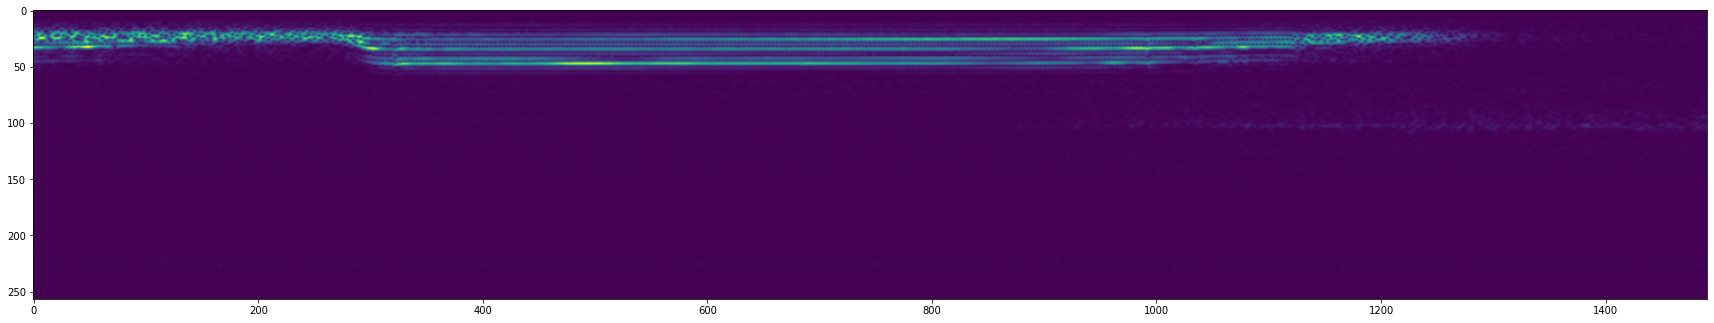

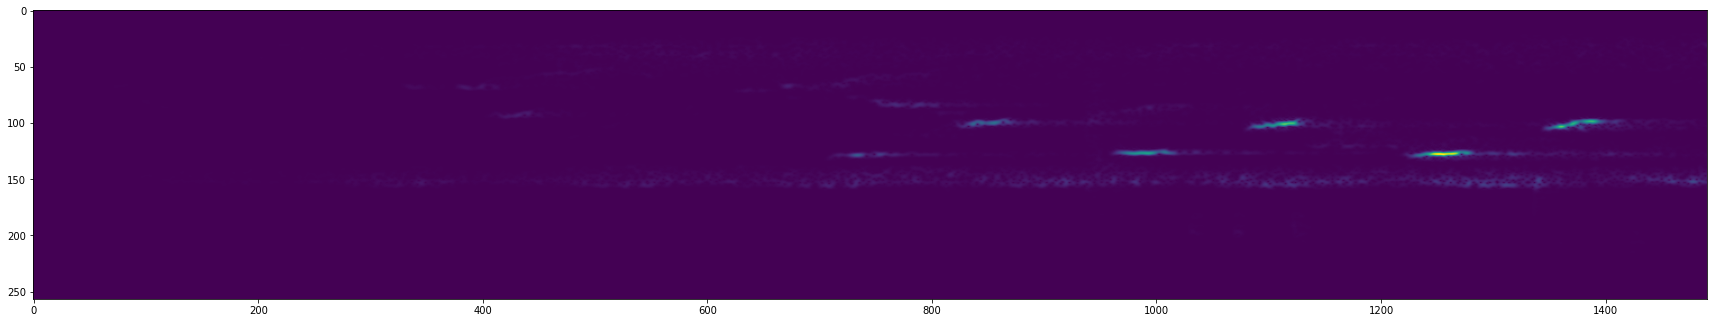

In [555]:
''' Positive spectogram example '''
spectogram, _ = convert_wav_to_spectogram(CAPUCHIN_FILE_EXAMPLE, 0)

plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

''' Negative spectogram example '''
spectogram, _ = convert_wav_to_spectogram(NON_CAPUCHIN_FILE_EXAMPLE, 0)

plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [559]:
''' Create a train/test partitions '''
''' Create a tensorflow data pipeline '''
data = ds.map(convert_wav_to_spectogram)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

''' Train/test split '''
x_train = data.take(36)
x_test = data.skip(36).take(15)